In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm1b.1_0h 04 arm1b.1_2h 05 arm1b.2_0h 06 arm1b.2_2h
1 0.8970954 27.92206            NA            NA     1.3256194      27.98665
2 0.8312379 27.92206            NA            NA     0.7613684      27.03332
3 1.3410224 27.53765            NA            NA     0.9908006      26.47698
4        NA       NA            NA            NA            NA            NA
5 1.1513555 36.33614            NA            NA     1.0472941      37.96680
6 0.9159453 35.58835            NA            NA     1.0328757      33.28192
  07 flg22_0h 08 flg22_2h   Group
1   0.8970954    61.10986 Trial01
2   0.8312379    63.26490 Trial01
3   1.3410224    61.10986 Trial01
4          NA          NA    <NA>
5   1.0163049    71.17671 Trial02
6   0.9614831    74.19928 Trial02
# A tibble: 6 × 3
  ind           Group   values
  <chr>         <chr>    <dbl>
1 01 wt_0h      Trial01  0.897
2 02 wt_2h      Trial01 27.9  
3 03 arm1b.1_0h Trial01 NA    
4 04 arm1b.1_2h Trial01 NA    
5 05 arm1b.2_0h Tri

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  0.897
2 01 wt_0h  Trial01  0.831
3 01 wt_0h  Trial01  1.34 
4 02 wt_2h  Trial01 27.9  
5 02 wt_2h  Trial01 27.9  
6 02 wt_2h  Trial01 27.5  


[1] 52 53

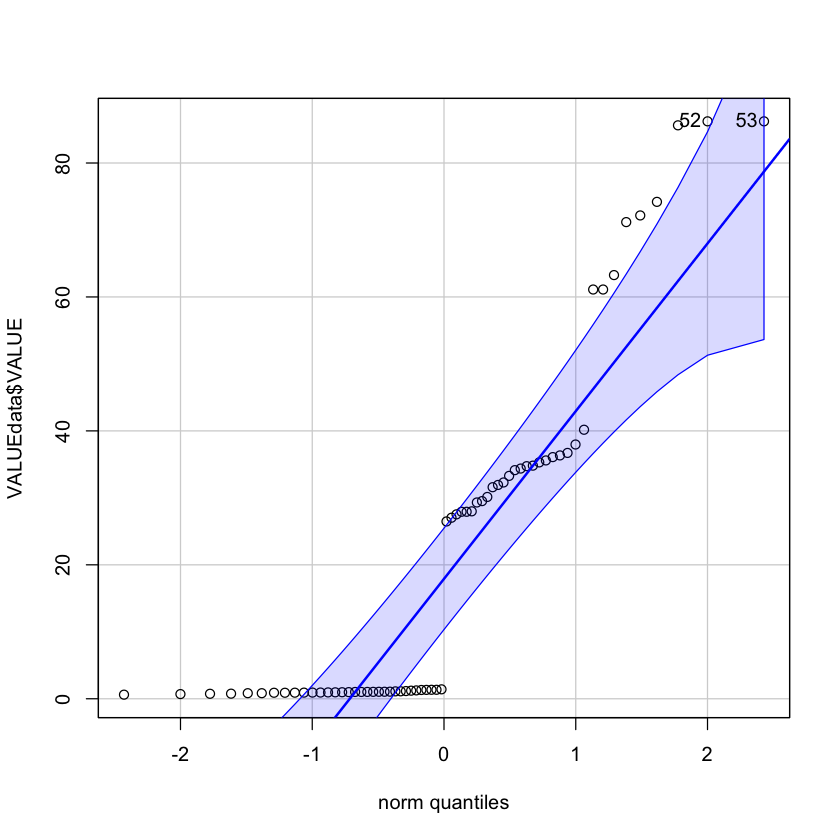

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   384.5    406.4   -182.3    364.5       56 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5224 -0.5720 -0.1062  0.5172  2.7830 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  7.136   2.671   
 Residual             12.738   3.569   
Number of obs: 66, groups:  Trial, 4

Fixed effects:
                       Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)              1.0179     1.6869  7.4755   0.603    0.564    
Treatment02 wt_2h       32.6331     1.4571 61.6201  22.396   <2e-16 ***
Treatment03 arm1b.1_0h  -2.1428     1.8620 63.4229  -1.151    0.254    
Treatment04 arm1b.1_2h  28.6207     1.8620 63.4229  15.371   <2e-16 ***
Treatment05 arm1b.2_0h   2.1329     1.8620 63.4229   1.145    0.256    
Treatment06 arm1b.2_2

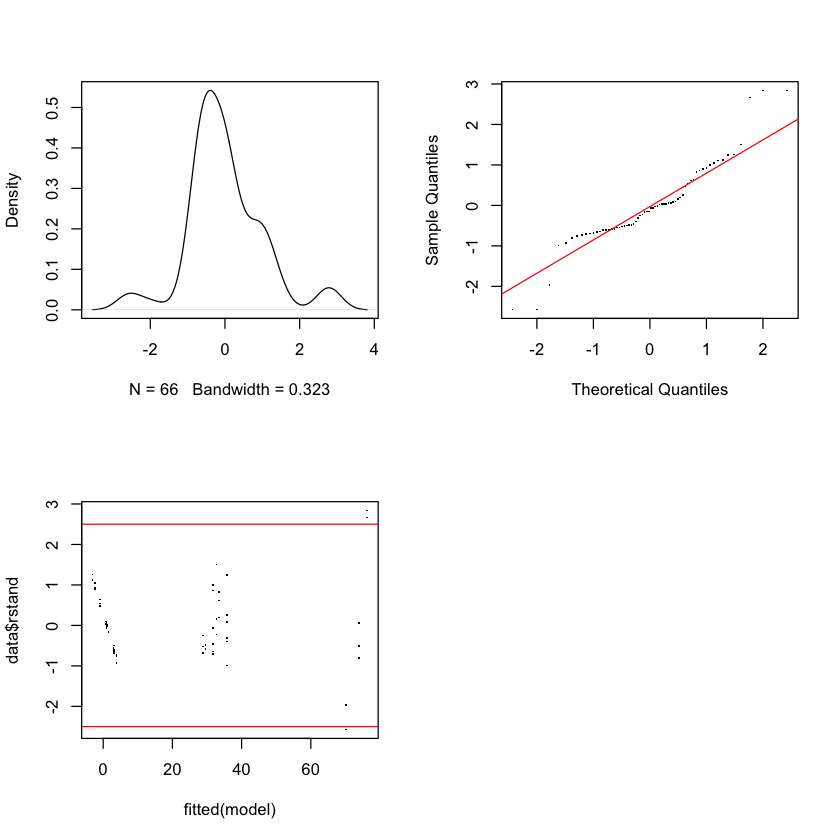

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF          F value     
 Min.   :40889   Min.   :5841   Min.   :7   Min.   :62.31   Min.   :458.6  
 1st Qu.:40889   1st Qu.:5841   1st Qu.:7   1st Qu.:62.31   1st Qu.:458.6  
 Median :40889   Median :5841   Median :7   Median :62.31   Median :458.6  
 Mean   :40889   Mean   :5841   Mean   :7   Mean   :62.31   Mean   :458.6  
 3rd Qu.:40889   3rd Qu.:5841   3rd Qu.:7   3rd Qu.:62.31   3rd Qu.:458.6  
 Max.   :40889   Max.   :5841   Max.   :7   Max.   :62.31   Max.   :458.6  
     Pr(>F)         
 Min.   :4.546e-51  
 1st Qu.:4.546e-51  
 Median :4.546e-51  
 Mean   :4.546e-51  
 3rd Qu.:4.546e-51  
 Max.   :4.546e-51  


Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                   Estimate Std. Error z value Pr(>|z|)    
02 wt_2h - 01 wt_0h == 0            32.6331     1.4571  22.396   <0.001 ***
03 arm1b.1_0h - 01 wt_0h == 0       -2.1428     1.8620  -1.151    0.943    
04 arm1b.1_2h - 01 wt_0h == 0       28.6207     1.8620  15.371   <0.001 ***
05 arm1b.2_0h - 01 wt_0h == 0        2.1329     1.8620   1.145    0.944    
06 arm1b.2_2h - 01 wt_0h == 0       31.8978     1.8620  17.131   <0.001 ***
07 flg22_0h - 01 wt_0h == 0          0.7287     1.6034   0.454    1.000    
08 flg22_2h - 01 wt_0h == 0         73.1580     1.6034  45.626   <0.001 ***
03 arm1b.1_0h - 02 wt_2h == 0      -34.7759     1.8620 -18.677   <0.001 ***
04 arm1b.1_2h - 02 wt_2h == 0       -4.0125     1.8620  -2.155    0.371    
05 arm1b.2_0h - 02 wt_2h == 